# LSTM model

In this notebook is explained the pipeline for the construction of an **LSTM** based trajectory clasification model. For this, we will need some libraries:

- `pickle`: Storing the models histories.
- `matplotlib`: Results visualization
- `tensorflow`: Modeling
- `sklearn`: Preprocessing and spliting the data

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, callbacks

from data_handler import get_selected_data

2022-06-23 20:26:39.337085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 20:26:39.337109: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading the data

In [2]:
data = get_selected_data()

Let's get the trajectory data and their classes

In [3]:
trajectories = [tmd["traj_data"] for tmd in data]
classes = [tmd["class"] for tmd in data]

## Labeling the classes

Now we need to label the classes, we'll be using a LabelEncoder for that.

In [4]:
le = preprocessing.LabelEncoder()
le.fit(classes)
for cls, lbl in zip(le.classes_, le.transform(le.classes_)):
    print(lbl, cls)
labeled_classes = le.transform(classes)

0 bike
1 bus
2 car
3 train
4 walk


## Splitting training and test

The data will be splitted in 80% training (validation will be extracted from this) and 20% test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    trajectories,
    labeled_classes,
    stratify=labeled_classes,
    random_state=0,
    test_size=0.20,
)

Some function that will be used in the next cells

In [6]:
def clamp_data(trajs, hist_size=75):
    """Gets the last n points of a trajectory."""
    return np.array([traj[-hist_size:] for traj in trajs])

def plot_model_results(history):
    """Plots the model history results."""
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def save_history(model, file_name="history"):
    """Saves the history of a model."""
    with open(file_name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    return model

def get_model():
    """Builds a model."""
    model = keras.Sequential()
    model.add(layers.LSTM(128, input_shape=(last_n_points, 3), return_sequences=True))
    model.add(layers.LSTM(64, input_shape=(last_n_points, 3), return_sequences=True))
    model.add(layers.Bidirectional(layers.LSTM(32, input_shape=(last_n_points, 3)), merge_mode="ave"))
    model.add(layers.Dense(15, activation="relu"))
    model.add(layers.Dense(5, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model

## Preparing the data

So, the data is prepared to be used in the model:

In [7]:
last_n_points = 100
X_train = clamp_data(X_train, last_n_points)
X_test = clamp_data(X_test, last_n_points)

## Training the model

Let's se how it goes...

In [8]:
model = get_model()
model.summary()
es = callbacks.EarlyStopping(monitor="loss", mode="min", verbose=1, patience=5)
mc = callbacks.ModelCheckpoint(
    "best_model.h5", monitor="accuracy", mode="max", verbose=1, save_best_only=True
)
history = model.fit(X_train, np.array(y_train), epochs=30, callbacks=[mc, es], validation_split=0.2)

2022-06-23 20:26:46.017935: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-23 20:26:46.017955: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-23 20:26:46.017974: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jmlap): /proc/driver/nvidia/version does not exist
2022-06-23 20:26:46.018192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          67584     
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           49408     
                                                                 
 bidirectional (Bidirectiona  (None, 32)               24832     
 l)                                                              
                                                                 
 dense (Dense)               (None, 15)                495       
                                                                 
 dense_1 (Dense)             (None, 5)                 80        
                                                                 
Total params: 142,399
Trainable params: 142,399
Non-trainable params: 0
__________________________________________________

79/79 [==============================] - ETA: 0s - loss: 1.3494 - accuracy: 0.4637
Epoch 26: accuracy did not improve from 0.47206
79/79 [==============================] - 6s 75ms/step - loss: 1.3494 - accuracy: 0.4637 - val_loss: 1.3138 - val_accuracy: 0.5166
Epoch 27/30
79/79 [==============================] - ETA: 0s - loss: 1.3507 - accuracy: 0.4713
Epoch 27: accuracy did not improve from 0.47206
79/79 [==============================] - 6s 76ms/step - loss: 1.3507 - accuracy: 0.4713 - val_loss: 1.3268 - val_accuracy: 0.4945
Epoch 28/30
79/79 [==============================] - ETA: 0s - loss: 1.3518 - accuracy: 0.4677
Epoch 28: accuracy did not improve from 0.47206
79/79 [==============================] - 6s 76ms/step - loss: 1.3518 - accuracy: 0.4677 - val_loss: 1.3176 - val_accuracy: 0.5119
Epoch 29/30
79/79 [==============================] - ETA: 0s - loss: 1.3528 - accuracy: 0.4693
Epoch 29: accuracy did not improve from 0.47206
79/79 [==============================] - 6s 75ms/s

Well, the accuracy is not that good ;(

Let's se the plots and evaluate the model with the test set

## Results

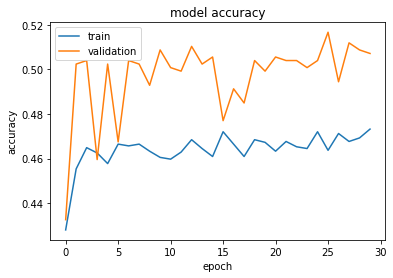

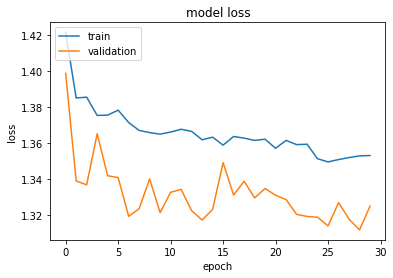

In [9]:
save_history(history.history, "best_model_history")
plot_model_results(history.history)

As the plots show, the accuracy is very unprobable to reach 50%

## Evaluation

In [10]:
print(model.evaluate(X_test, y_test))

25/25 [==============================] - 1s 24ms/step - loss: 1.3770 - accuracy: 0.4499
[1.3769865036010742, 0.4499366283416748]


## Some predictions

Let's see some predictions..

In [11]:
def predict(trajs, model, hist_size=75, cls = None):
    if cls is None:
        cls = [""] * len(trajs)
    for traj, cl in zip(trajs, cls):
        X = clamp_data([traj], hist_size)
        pred = model.predict(X)
        print(pred[-1], np.argmax(pred[-1], axis=0), cl)

In [12]:
predict(X_test[10:25], model, last_n_points, y_test[10:25])

1/1 [==============================] - 1s 737ms/step
[0.21146321 0.16739985 0.08904822 0.1484687  0.38361993] 4 4
1/1 [==============================] - 0s 18ms/step
[0.25185794 0.19596711 0.0832426  0.05633022 0.41260216] 4 0
1/1 [==============================] - 0s 17ms/step
[0.05081495 0.0672042  0.09200395 0.07959742 0.7103794 ] 4 4
1/1 [==============================] - 0s 18ms/step
[0.22270137 0.20037863 0.07594009 0.06049509 0.44048488] 4 4
1/1 [==============================] - 0s 17ms/step
[0.10310944 0.17511383 0.06516486 0.10458138 0.55203056] 4 4
1/1 [==============================] - 0s 16ms/step
[0.1749779  0.22269438 0.04660655 0.03793234 0.5177888 ] 4 1
1/1 [==============================] - 0s 16ms/step
[0.17046225 0.41389802 0.16387221 0.10787784 0.14388967] 1 1
1/1 [==============================] - 0s 17ms/step
[0.19820179 0.3851371  0.16336253 0.10743285 0.14586574] 1 2
1/1 [==============================] - 0s 17ms/step
[0.23926078 0.35028416 0.14757283 0.1145461

As we can see, generarlly the classes 0 and 4 (bike and walk) where predicted correctly, unlike the clases 1 and 2 (bus and car).

Let's reduce the classes to be only bike, car and walk (which are very different kind of trajectories) and redo all the process.

## Reselecting the data

In [13]:
trajectories = [
    tmd["traj_data"]
    for tmd in data
    if tmd["class"] != "train" and tmd["class"] != "bus"
]
classes = [
    tmd["class"] for tmd in data if tmd["class"] != "train" and tmd["class"] != "bus"
]

le = preprocessing.LabelEncoder()
le.fit(classes)
for cls, lbl in zip(le.classes_, le.transform(le.classes_)):
    print(lbl, cls)
labeled_classes = le.transform(classes)

0 bike
1 car
2 walk


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    trajectories,
    labeled_classes,
    stratify=labeled_classes,
    random_state=0,
    test_size=0.20,
)

last_n_points = 100
X_train = clamp_data(X_train, last_n_points)
X_test = clamp_data(X_test, last_n_points)

In [15]:
model = get_model()
model.summary()
es = callbacks.EarlyStopping(monitor="loss", mode="min", verbose=1, patience=5)
mc = callbacks.ModelCheckpoint(
    "best_model_3_cls.h5", monitor="accuracy", mode="max", verbose=1, save_best_only=True
)
history = model.fit(X_train, np.array(y_train), epochs=30, callbacks=[mc, es], validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 128)          67584     
                                                                 
 lstm_4 (LSTM)               (None, 100, 64)           49408     
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               24832     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 15)                495       
                                                                 
 dense_3 (Dense)             (None, 5)                 80        
                                                                 
Total params: 142,399
Trainable params: 142,399
Non-trainable params: 0
________________________________________________

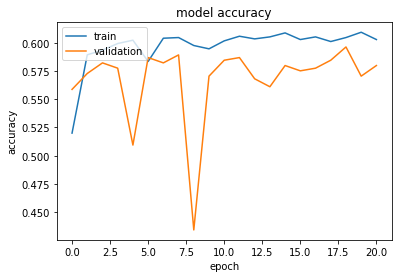

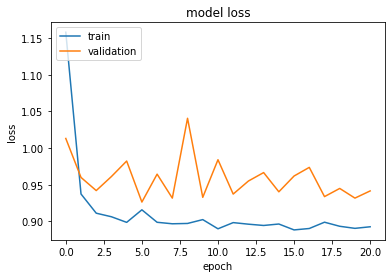

17/17 [==============================] - 1s 31ms/step - loss: 0.9082 - accuracy: 0.6004
[0.908164918422699, 0.600375235080719]


In [17]:
save_history(history.history, "best_model_3_cls_history")
plot_model_results(history.history)
print(model.evaluate(X_test, y_test))

As we can see, the model had better perfomance with this 3 classes.